Evaluate model epoch 4 no embedding

# LSTM model

In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import pickle

scaler_file = "../dataset/processed/scaler.pkl"

with open(scaler_file, 'rb') as f:
    scaler_X, scaler_y = pickle.load(f)

feature_cols = ["Latitude", "Longitude", "hour", "day", "month", "season", 
                "WS10M", "QV2M", "PS", "PRECTOTCORR", "T2M", "CLRSKY_SFC_SW_DWN"]

target_cols = ["CLRSKY_SFC_SW_DWN", "PS", "T2M", "QV2M", "WS10M", "PRECTOTCORR"] 

timesteps = 24
batch_size = 256

test_file = "../dataset/processed/test_data.csv"

checkpoint_path = "../model/best_model2.h5"
model = load_model(checkpoint_path)
model.summary()

def data_generator(file_path, feature_cols, target_cols, batch_size=256, timesteps=24):
    dtype_dict = {col: np.float32 for col in feature_cols + target_cols}
    dtype_dict.update({"hour": np.int8, "day": np.int8, "month": np.int8, "season": np.int8})

    for chunk in pd.read_csv(file_path, chunksize=batch_size * 5, dtype=dtype_dict, parse_dates=["Datetime"], low_memory=True):
        chunk = chunk.sort_values(by=["Datetime"])
        
        X_scaled = scaler_X.transform(chunk[feature_cols])
        y_scaled = scaler_y.transform(chunk[target_cols])

        X_batch, y_batch = [], []
        for i in range(len(chunk) - timesteps - 24):
            X_batch.append(X_scaled[i:i+timesteps])
            y_batch.append(y_scaled[i+timesteps:i+timesteps+24])

        yield np.array(X_batch), np.array(y_batch)

test_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(test_file, feature_cols, target_cols, batch_size, timesteps),
    output_signature=(
        tf.TensorSpec(shape=(None, timesteps, len(feature_cols)), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 24, len(target_cols)), dtype=tf.float32),
    )
).prefetch(tf.data.AUTOTUNE)

loss, mae = model.evaluate(test_dataset)
print(f"✅ Kết quả đánh giá trên dữ liệu test: Loss={loss:.4f}, MAE={mae:.4f}")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 128)           72192     
                                                                 
 dropout (Dropout)           (None, 24, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 144)               9360      
                                                                 
 reshape (Reshape)           (None, 24, 6)             0         
                                                                 
Total params: 130,960
Trainable params: 130,960
Non-trai

# Fine-tune & CNN-LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import pickle

scaler_file = "../dataset/processed/scaler.pkl"
with open(scaler_file, 'rb') as f:
    scaler_X, scaler_y = pickle.load(f)

feature_cols = ["Latitude", "Longitude", "hour", "day", "month", "season", 
                "WS10M", "QV2M", "PS", "PRECTOTCORR", "T2M", "CLRSKY_SFC_SW_DWN"]
target_cols = ["CLRSKY_SFC_SW_DWN", "PS", "T2M", "QV2M", "WS10M", "PRECTOTCORR"] 

timesteps = 24
batch_size = 256

test_file = "../dataset/processed/test_data.csv"
checkpoint_path = "best_model_spatial.h5"
model = load_model(checkpoint_path)

print("Model: \"sequential\"")
model.summary()

def data_generator(file_path, feature_cols, target_cols, batch_size=256, timesteps=24):
    dtype_dict = {col: np.float32 for col in feature_cols + target_cols}
    dtype_dict.update({"hour": np.int8, "day": np.int8, "month": np.int8, "season": np.int8})

    for chunk in pd.read_csv(file_path, chunksize=batch_size * 5, dtype=dtype_dict, parse_dates=["Datetime"], low_memory=True):
        chunk = chunk.sort_values(by=["Datetime", "Latitude", "Longitude"])
        
        X_scaled = scaler_X.transform(chunk[feature_cols])
        y_scaled = scaler_y.transform(chunk[target_cols])

        X_batch, y_batch = [], []
        for i in range(len(chunk) - timesteps - 24):
            X_batch.append(X_scaled[i:i+timesteps])
            y_batch.append(y_scaled[i+timesteps:i+timesteps+24])

        yield np.array(X_batch), np.array(y_batch)

test_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(test_file, feature_cols, target_cols, batch_size, timesteps),
    output_signature=(
        tf.TensorSpec(shape=(None, timesteps, len(feature_cols)), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 24, len(target_cols)), dtype=tf.float32),
    )
).prefetch(tf.data.AUTOTUNE)

print("\nĐang đánh giá mô hình trên tập test...")
loss, mae = model.evaluate(test_dataset, verbose=1)
print(f"✅ Kết quả đánh giá trên dữ liệu test: Loss={loss:.4f}, MAE={mae:.4f}")

Model: "sequential"
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 128)           72192     
                                                                 
 dropout (Dropout)           (None, 24, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 144)               9360      
                                                                 
 reshape (Reshape)           (None, 24, 6)             0         
                                                                 
Total params: 130,960
Trainable para

# Fine-tune LSTM

In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import pickle

scaler_file = "../dataset/processed/scaler.pkl"
with open(scaler_file, 'rb') as f:
    scaler_X, scaler_y = pickle.load(f)

feature_cols = ["Latitude", "Longitude", "hour", "day", "month", "season", 
                "WS10M", "QV2M", "PS", "PRECTOTCORR", "T2M", "CLRSKY_SFC_SW_DWN"]
target_cols = ["CLRSKY_SFC_SW_DWN", "PS", "T2M", "QV2M", "WS10M", "PRECTOTCORR"] 

timesteps = 24
batch_size = 256

test_file = "../dataset/processed/test_data.csv"
checkpoint_path = "best_model_spatial.h5"
model = load_model(checkpoint_path)

print("Model: \"sequential\"")
model.summary()

def data_generator(file_path, feature_cols, target_cols, batch_size=256, timesteps=24):
    dtype_dict = {col: np.float32 for col in feature_cols + target_cols}
    dtype_dict.update({"hour": np.int8, "day": np.int8, "month": np.int8, "season": np.int8})

    for chunk in pd.read_csv(file_path, chunksize=batch_size * 5, dtype=dtype_dict, parse_dates=["Datetime"], low_memory=True):
        chunk = chunk.sort_values(by=["Datetime", "Latitude", "Longitude"])
        
        X_scaled = scaler_X.transform(chunk[feature_cols])
        y_scaled = scaler_y.transform(chunk[target_cols])

        X_batch, y_batch = [], []
        for i in range(len(chunk) - timesteps - 24):
            X_batch.append(X_scaled[i:i+timesteps])
            y_batch.append(y_scaled[i+timesteps:i+timesteps+24])

        yield np.array(X_batch), np.array(y_batch)

test_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(test_file, feature_cols, target_cols, batch_size, timesteps),
    output_signature=(
        tf.TensorSpec(shape=(None, timesteps, len(feature_cols)), dtype=tf.float32), 
        tf.TensorSpec(shape=(None, 24, len(target_cols)), dtype=tf.float32),
    )
).prefetch(tf.data.AUTOTUNE)

print("\nĐang đánh giá mô hình trên tập test...")
loss, mae = model.evaluate(test_dataset, verbose=1)
print(f"✅ Kết quả đánh giá trên dữ liệu test: Loss={loss:.4f}, MAE={mae:.4f}")

Model: "sequential"
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 128)           72192     
                                                                 
 dropout (Dropout)           (None, 24, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 144)               9360      
                                                                 
 reshape (Reshape)           (None, 24, 6)             0         
                                                                 
Total params: 130,960
Trainable para

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Đọc dữ liệu đã xử lý

def load_processed_data():
    df_day_20_scaled = pd.read_csv('../dataset/weather_data_25.csv')
    df_day_21_scaled = pd.read_csv('../dataset/weather_data_26.csv')
    return df_day_20_scaled, df_day_21_scaled

# Đổi tên cột PRECTOT thành PRECTOTCORR để phù hợp với mô hình

def add_time_features(df):
    df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')
    df['hour'] = df['Datetime'].dt.hour
    df['day'] = df['Datetime'].dt.day
    df['month'] = df['Datetime'].dt.month
    df['season'] = (df['month'] % 12 + 3) // 3  # Tính mùa (1 - 4)

    if 'PRECTOT' in df.columns:
        df['PRECTOTCORR'] = df['PRECTOT']
        df = df.drop(columns=['PRECTOT'])

    return df

# Hàm tạo dữ liệu LSTM đầu vào

def create_lstm_input(df, time_steps=24):
    X = []
    y = []

    df = add_time_features(df)

    features = ['T2M', 'QV2M', 'PS', 'WS10M', 'PRECTOTCORR', 'CLRSKY_SFC_SW_DWN',
                'hour', 'day', 'month', 'season', 'Latitude', 'Longitude']

    for i in range(len(df) - time_steps):
        X.append(df.iloc[i:i+time_steps][features].values)
        y.append(df.iloc[i+time_steps][features[:6]].values)

    return np.array(X), np.array(y)

# Dự báo với mô hình cho một cặp tọa độ

def predict_with_model_for_lat_lon(df_day_20_scaled, lat, lon, scaler_X, scaler_y, model):
    df_lat_lon = df_day_20_scaled[(df_day_20_scaled['Latitude'] == lat) & (df_day_20_scaled['Longitude'] == lon)].copy()

    if len(df_lat_lon) == 0:
        print(f"No data for lat {lat}, lon {lon}")
        return None, None

    X_input, _ = create_lstm_input(df_lat_lon, time_steps=24)

    if X_input.shape[0] == 0:
        print(f"Not enough data for prediction at lat {lat}, lon {lon}")
        return None, None

    features = ['T2M', 'QV2M', 'PS', 'WS10M', 'PRECTOTCORR', 'CLRSKY_SFC_SW_DWN',
                'hour', 'day', 'month', 'season', 'Latitude', 'Longitude']
    X_input_df = pd.DataFrame(X_input.reshape(-1, len(features)), columns=features)
    X_input_df = X_input_df[scaler_X.feature_names_in_]
    X_input_scaled = scaler_X.transform(X_input_df).reshape(X_input.shape)

    y_pred_scaled = model.predict(X_input_scaled)
    last_prediction_scaled = y_pred_scaled[-1, -1, :].reshape(1, -1)
    last_prediction = scaler_y.inverse_transform(last_prediction_scaled)

    result = df_lat_lon.iloc[-1:].copy()
    result[['Predicted_T2M', 'Predicted_QV2M', 'Predicted_PS', 'Predicted_WS10M',
            'Predicted_PRECTOT', 'Predicted_CLRSKY_SFC_SW_DWN']] = last_prediction

    return result, scaler_y.inverse_transform(y_pred_scaled)

# Hàm dự báo cho tất cả các cặp tọa độ

def forecast_for_all_lat_lon(df_day_20_scaled, scaler_X, scaler_y):
    model = load_model('best_model_fine_tune.h5')

    latitudes = np.arange(8, 25, 1)
    longitudes = np.arange(102, 119, 1)

    forecast_results = pd.DataFrame()

    for lat in latitudes:
        for lon in longitudes:
            df_lat_lon, y_pred = predict_with_model_for_lat_lon(df_day_20_scaled, lat, lon, scaler_X, scaler_y, model)
            if df_lat_lon is not None:
                forecast_results = pd.concat([forecast_results, df_lat_lon], axis=0)

    return forecast_results

# Đánh giá mô hình

def evaluate_model(df_day_21_scaled, forecast_results):
    df_day_21_scaled['Datetime'] = pd.to_datetime(df_day_21_scaled['Datetime'], errors='coerce')
    forecast_results['Datetime'] = pd.to_datetime(forecast_results['Datetime'], errors='coerce')

    merged = pd.merge(df_day_21_scaled, forecast_results,
                      on=['Datetime', 'Latitude', 'Longitude'],
                      how='inner', suffixes=('', '_pred'))

    if len(merged) == 0:
        print("No matching data for evaluation")
        return

    metrics = {}
    for col in ['T2M', 'QV2M', 'PS', 'WS10M', 'PRECTOT', 'CLRSKY_SFC_SW_DWN']:
        actual = merged[col]
        pred = merged[f'Predicted_{col}']
        metrics[col] = {
            'MAE': mean_absolute_error(actual, pred),
            'MSE': mean_squared_error(actual, pred),
            'R2': r2_score(actual, pred)
        }

    for col, values in metrics.items():
        print(f"\nMetrics for {col}:")
        print(f"MAE: {values['MAE']:.4f}")
        print(f"MSE: {values['MSE']:.4f}")
        print(f"R2: {values['R2']:.4f}")

# Vẽ biểu đồ cho một vị trí cụ thể

def plot_results_for_location(df_day_21_scaled, forecast_results, lat, lon):
    location_data = forecast_results[
        (forecast_results['Latitude'] == lat) &
        (forecast_results['Longitude'] == lon)
    ]

    if len(location_data) == 0:
        print(f"No data for lat {lat}, lon {lon}")
        return

    actual_data = df_day_21_scaled[
        (df_day_21_scaled['Latitude'] == lat) &
        (df_day_21_scaled['Longitude'] == lon)
    ]

    if len(actual_data) == 0:
        print(f"No actual data for lat {lat}, lon {lon}")
        return

    columns_to_plot = ['T2M', 'QV2M', 'PS', 'WS10M', 'PRECTOT', 'CLRSKY_SFC_SW_DWN']

    plt.figure(figsize=(15, 10))

    for i, col in enumerate(columns_to_plot, 1):
        plt.subplot(3, 2, i)
        plt.plot(actual_data['Datetime'], actual_data[col], label=f'Actual {col}', color='blue')
        plt.plot(location_data['Datetime'], location_data[f'Predicted_{col}'],
                 label=f'Predicted {col}', color='red', linestyle='--')
        plt.xlabel('Datetime')
        plt.ylabel(col)
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.title(f'{col} at lat {lat}, lon {lon}')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    df_day_20_scaled, df_day_21_scaled = load_processed_data()

    # Chuẩn hóa dữ liệu
    df_day_20_scaled = add_time_features(df_day_20_scaled)
    df_day_21_scaled = add_time_features(df_day_21_scaled)

    feature_cols = ['T2M', 'QV2M', 'PS', 'WS10M', 'PRECTOTCORR', 'CLRSKY_SFC_SW_DWN',
                    'hour', 'day', 'month', 'season', 'Latitude', 'Longitude']
    target_cols = ['T2M', 'QV2M', 'PS', 'WS10M', 'PRECTOTCORR', 'CLRSKY_SFC_SW_DWN']

    with open('../dataset/scaler.pkl', 'rb') as f:
        scaler_X, scaler_y = pickle.load(f)

    df_day_20_scaled_scaled = pd.DataFrame(
        scaler_X.transform(df_day_20_scaled[scaler_X.feature_names_in_]),
        columns=scaler_X.feature_names_in_,
        index=df_day_20_scaled.index
    )
    df_day_20_scaled[scaler_X.feature_names_in_] = df_day_20_scaled_scaled

    df_day_21_scaled_scaled = pd.DataFrame(
        scaler_X.transform(df_day_21_scaled[scaler_X.feature_names_in_]),
        columns=scaler_X.feature_names_in_,
        index=df_day_21_scaled.index
    )
    df_day_21_scaled[scaler_X.feature_names_in_] = df_day_21_scaled_scaled


    forecast_results = forecast_for_all_lat_lon(df_day_20_scaled, scaler_X, scaler_y)

    if len(forecast_results) > 0:
        evaluate_model(df_day_21_scaled, forecast_results)
        plot_results_for_location(df_day_21_scaled, forecast_results, lat=10, lon=105)
    else:
        print("No forecast results to evaluate")

No data for lat 8, lon 102
No data for lat 8, lon 103
No data for lat 8, lon 104
No data for lat 8, lon 105
No data for lat 8, lon 106
No data for lat 8, lon 107
No data for lat 8, lon 108
No data for lat 8, lon 109
No data for lat 8, lon 110
No data for lat 8, lon 111
No data for lat 8, lon 112
No data for lat 8, lon 113
No data for lat 8, lon 114
No data for lat 8, lon 115
No data for lat 8, lon 116
No data for lat 8, lon 117
No data for lat 8, lon 118
No data for lat 9, lon 102
No data for lat 9, lon 103
No data for lat 9, lon 104
No data for lat 9, lon 105
No data for lat 9, lon 106
No data for lat 9, lon 107
No data for lat 9, lon 108
No data for lat 9, lon 109
No data for lat 9, lon 110
No data for lat 9, lon 111
No data for lat 9, lon 112
No data for lat 9, lon 113
No data for lat 9, lon 114
No data for lat 9, lon 115
No data for lat 9, lon 116
No data for lat 9, lon 117
No data for lat 9, lon 118
No data for lat 10, lon 102
No data for lat 10, lon 103
No data for lat 10, lon 10

18/18 [==============================] - 0s 7ms/step
No matching data for evaluation


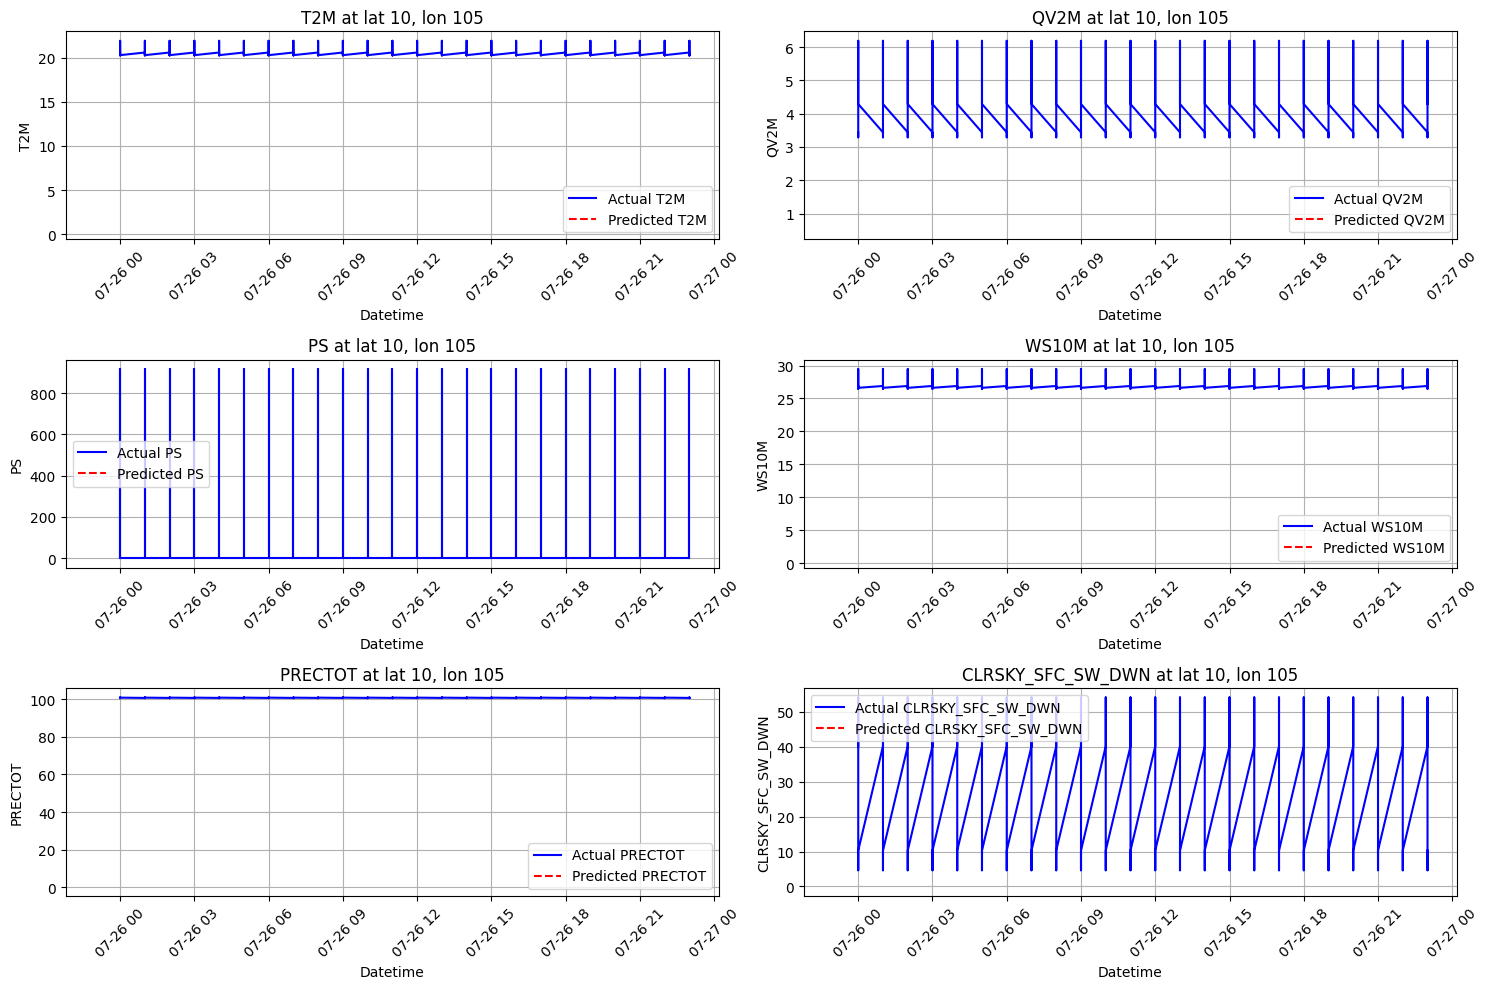

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Đọc dữ liệu đã xử lý
def load_processed_data():
    df_day_20_scaled = pd.read_csv('../dataset/weather_chunks/weather_data_25.csv')
    df_day_21_scaled = pd.read_csv('../dataset/weather_chunks/weather_data_26.csv')
    return df_day_20_scaled, df_day_21_scaled

# Đổi tên cột PRECTOT thành PRECTOTCORR để phù hợp với mô hình
def add_time_features(df):
    df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')
    df['hour'] = df['Datetime'].dt.hour
    df['day'] = df['Datetime'].dt.day
    df['month'] = df['Datetime'].dt.month
    df['season'] = (df['month'] % 12 + 3) // 3  # Tính mùa (1 - 4)

    # Đổi tên cột PRECTOT thành PRECTOTCORR để phù hợp với mô hình đã huấn luyện
    if 'PRECTOT' in df.columns:  # Kiểm tra xem cột PRECTOT có tồn tại không
        df['PRECTOTCORR'] = df['PRECTOT']  # Đổi tên cột PRECTOT thành PRECTOTCORR
        df = df.drop(columns=['PRECTOT'])  # Loại bỏ cột cũ PRECTOT nếu không cần

    return dfgit 

# Hàm tạo dữ liệu LSTM đầu vào
def create_lstm_input(df, time_steps=24):
    X = []
    y = []
    
    df = add_time_features(df)
    
    # Đảm bảo sử dụng đúng 12 features như khi huấn luyện
    features = ['T2M', 'QV2M', 'PS', 'WS10M', 'PRECTOTCORR', 'CLRSKY_SFC_SW_DWN', 
                'hour', 'day', 'month', 'season', 'Latitude', 'Longitude']
    
    for i in range(len(df) - time_steps):
        X.append(df.iloc[i:i+time_steps][features].values)
        y.append(df.iloc[i+time_steps][features[:6]].values)  # Chỉ lấy 6 features đầu cho y
    
    return np.array(X), np.array(y)

# Dự báo với mô hình cho một cặp tọa độ
def predict_with_model_for_lat_lon(df_day_20_scaled, lat, lon, scaler_X, scaler_y, model):
    df_lat_lon = df_day_20_scaled[(df_day_20_scaled['Latitude'] == lat) & (df_day_20_scaled['Longitude'] == lon)].copy()
    
    if len(df_lat_lon) == 0:
        print(f"No data for lat {lat}, lon {lon}")
        return None, None
    
    # Tạo dữ liệu đầu vào cho mô hình với 24 bước thời gian
    X_input, _ = create_lstm_input(df_lat_lon, time_steps=24)
    
    if X_input.shape[0] == 0:
        print(f"Not enough data for prediction at lat {lat}, lon {lon}")
        return None, None
    
    # Đảm bảo rằng X_input có đúng tên cột để phù hợp với scaler
    features = ['T2M', 'QV2M', 'PS', 'WS10M', 'PRECTOTCORR', 'CLRSKY_SFC_SW_DWN', 
                'hour', 'day', 'month', 'season', 'Latitude', 'Longitude']
    X_input_df = pd.DataFrame(X_input.reshape(-1, len(features)), columns=features)
    
    # Đảm bảo thứ tự cột khớp với thứ tự cột trong scaler_X
    X_input_df = X_input_df[scaler_X.feature_names_in_]  # Đảm bảo thứ tự cột khớp
    
    # Reshape và chuẩn hóa
    X_input_scaled = scaler_X.transform(X_input_df).reshape(X_input.shape)
    
    # Dự báo
    y_pred = model.predict(X_input_scaled)
    
    # Lấy dự đoán cuối cùng
    last_prediction = y_pred[-1, -1, :]
    
    # Tạo DataFrame kết quả
    result = df_lat_lon.iloc[-1:].copy()
    result[['Predicted_T2M', 'Predicted_QV2M', 'Predicted_PS', 'Predicted_WS10M', 
            'Predicted_PRECTOT', 'Predicted_CLRSKY_SFC_SW_DWN']] = last_prediction.reshape(1, -1)
    
    return result, y_pred

# Hàm dự báo cho tất cả các cặp tọa độ
def forecast_for_all_lat_lon(df_day_20_scaled, scaler_X, scaler_y):
    model = load_model('best_model_fine_tune.h5')
    
    latitudes = np.arange(8, 25, 1)
    longitudes = np.arange(102, 119, 1)

    forecast_results = pd.DataFrame()

    for lat in latitudes:
        for lon in longitudes:
            df_lat_lon, y_pred = predict_with_model_for_lat_lon(df_day_20_scaled, lat, lon, scaler_X, scaler_y, model)
            if df_lat_lon is not None:
                forecast_results = pd.concat([forecast_results, df_lat_lon], axis=0)
    
    return forecast_results

# Đánh giá mô hình
def evaluate_model(df_day_21_scaled, forecast_results):
    # Chuyển đổi kiểu dữ liệu của cột 'Datetime' về datetime64[ns]
    df_day_21_scaled['Datetime'] = pd.to_datetime(df_day_21_scaled['Datetime'], errors='coerce')
    forecast_results['Datetime'] = pd.to_datetime(forecast_results['Datetime'], errors='coerce')
    
    # Merge dựa trên các cột chung (Datetime, Latitude, Longitude)
    merged = pd.merge(df_day_21_scaled, forecast_results, 
                     on=['Datetime', 'Latitude', 'Longitude'], 
                     how='inner', suffixes=('', '_pred'))
    
    if len(merged) == 0:
        print("No matching data for evaluation")
        return
    
    metrics = {}
    for col in ['T2M', 'QV2M', 'PS', 'WS10M', 'PRECTOT', 'CLRSKY_SFC_SW_DWN']:
        actual = merged[col]
        pred = merged[f'Predicted_{col}']
        metrics[col] = {
            'MAE': mean_absolute_error(actual, pred),
            'MSE': mean_squared_error(actual, pred),
            'R2': r2_score(actual, pred)
        }
    
    for col, values in metrics.items():
        print(f"\nMetrics for {col}:")
        print(f"MAE: {values['MAE']:.4f}")
        print(f"MSE: {values['MSE']:.4f}")
        print(f"R2: {values['R2']:.4f}")

# Vẽ biểu đồ cho một vị trí cụ thể
def plot_results_for_location(df_day_21_scaled, forecast_results, lat, lon):
    location_data = forecast_results[ 
        (forecast_results['Latitude'] == lat) & 
        (forecast_results['Longitude'] == lon)
    ]
    
    if len(location_data) == 0:
        print(f"No data for lat {lat}, lon {lon}")
        return
    
    actual_data = df_day_21_scaled[
        (df_day_21_scaled['Latitude'] == lat) & 
        (df_day_21_scaled['Longitude'] == lon)
    ]
    
    if len(actual_data) == 0:
        print(f"No actual data for lat {lat}, lon {lon}")
        return
    
    columns_to_plot = ['T2M', 'QV2M', 'PS', 'WS10M', 'PRECTOT', 'CLRSKY_SFC_SW_DWN']
    
    plt.figure(figsize=(15, 10))
    
    for i, col in enumerate(columns_to_plot, 1):
        plt.subplot(3, 2, i)
        plt.plot(actual_data['Datetime'], actual_data[col], label=f'Actual {col}', color='blue')
        plt.plot(location_data['Datetime'], location_data[f'Predicted_{col}'], 
                label=f'Predicted {col}', color='red', linestyle='--')
        plt.xlabel('Datetime')
        plt.ylabel(col)
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.title(f'{col} at lat {lat}, lon {lon}')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    df_day_20_scaled, df_day_21_scaled = load_processed_data()
    
    # Tải scaler đã lưu
    with open('../dataset/processed/scaler.pkl', 'rb') as f:
        scaler_X, scaler_y = pickle.load(f)

    forecast_results = forecast_for_all_lat_lon(df_day_20_scaled, scaler_X, scaler_y)
    
    if len(forecast_results) > 0:
        evaluate_model(df_day_21_scaled, forecast_results)
        
        # Vẽ biểu đồ cho một vị trí cụ thể (ví dụ lat=10, lon=105)
        plot_results_for_location(df_day_21_scaled, forecast_results, lat=10, lon=105)
    else:
        print("No forecast results to evaluate")
